In [1]:
import numpy as np
import scipy, time
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy import stats, integrate

#returns the step function value at each increment of the CDF
def cumcount_reduced(arr):
    '''Cumulative count of a array'''
    sorted_arr = np.array(sorted(arr))
    counts = np.zeros(len(arr))
    
    rolling_count = 0
    for idx, elem in enumerate(sorted_arr):
        rolling_count += 1
        counts[idx] = rolling_count

    counts /= len(counts)
    counts -= (1 / (2 * len(counts)))

    return (sorted_arr, counts)

#takes two datasets to estimate the relative entropy between their PDFs
#we use eps=10^-11, but it could be defined as < the minimal interval between data points
def KLD_PerezCruz(P, Q, eps=1e-11):
    '''KL divergence calculation'''
    P = sorted(P)
    Q = sorted(Q)
    
    P_positions, P_counts = cumcount_reduced(P)
    Q_positions, Q_counts = cumcount_reduced(Q)
    
    #definition of x_0 and x_{n+1}
    x_0 = np.min([P_positions[0], Q_positions[0]]) - 1
    P_positions = np.insert(P_positions, 0, [x_0])
    P_counts = np.insert(P_counts, 0, [0])
    Q_positions = np.insert(Q_positions, 0, [x_0])
    Q_counts = np.insert(Q_counts, 0, [0])
    
    x_np1 = np.max([P_positions[-1], Q_positions[-1]]) + 1
    P_positions = np.append(P_positions, [x_np1])
    P_counts = np.append(P_counts, [1])
    Q_positions = np.append(Q_positions, [x_np1])
    Q_counts = np.append(Q_counts, [1])
    
    f_P = interp1d(P_positions, P_counts)
    f_Q = interp1d(Q_positions, Q_counts) 
    
    X = P_positions[1:-2]
    values = (f_P(X) - f_P(X - eps)) / (f_Q(X) - f_Q(X - eps))
    filt = ((values != 0.) & ~(np.isinf(values)) & ~(np.isnan(values)))
    values_filter = values[filt]
    out = (np.sum(np.log(values_filter)) / len(values_filter)) - 1.

    return out

Generate two samples from different Gaussians

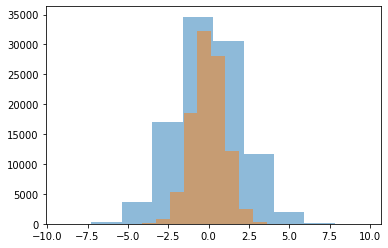

In [2]:
N_SIZE = 100000
μ1 = 0
μ2 = 0
std1 = 2
std2 = 1
P = np.random.normal(loc=μ1, scale=std1, size=N_SIZE)
Q = np.random.normal(loc=μ2, scale=std2, size=N_SIZE)

fig, ax = plt.subplots(1)
ax.hist(P, alpha=0.5)
ax.hist(Q, alpha=0.5)
plt.show()

Illustration of the CDF and the interpolation

In [3]:
#regular CDF
sorted_P = np.sort(P)
count_P = np.array(range(1,N_SIZE+1))/float(N_SIZE)

#reduced CDF and interpolation
sorted_P_reduced, count_P_reduced = cumcount_reduced(P)
interp = interp1d(sorted_P_reduced, count_P_reduced)

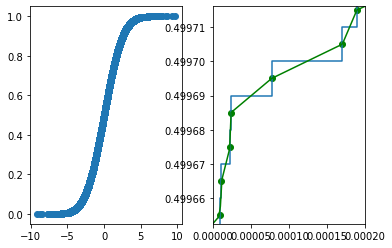

In [11]:
x_interp = np.linspace(0.0, .0002, 100)
y_interp = interp(x_interp)

fig, (ax1, ax2) = plt.subplots(1,2)

ax1.plot(sorted_P_reduced, count_P_reduced, marker='o')

ax2.plot(sorted_P, count_P,drawstyle='steps-post')
ax2.scatter(sorted_P_reduced, count_P_reduced,color='g')
ax2.plot(x_interp, y_interp, color='g')
plt.xlim(0.0, .0002)
plt.ylim(interp(0.0), interp(.0002))
plt.show()

Comparison to the correct value

In [5]:
%%time
μ1 = 0
μ2 = 0
std1 = 1
std2 = 1
N_SIZE = 1000000
import warnings
warnings.filterwarnings("ignore")

vec = []
for std1 in np.linspace(0.1,3,21):

    P = np.random.normal(loc=μ1, scale=std1, size=N_SIZE)
    Q = np.random.normal(loc=μ2, scale=std2, size=N_SIZE)

    dist_P = lambda x: scipy.stats.norm.pdf(x, μ1, std1)
    dist_Q = lambda x: scipy.stats.norm.pdf(x, μ2, std2)
    KLD = lambda x: dist_P(x)*np.log(dist_P(x)/dist_Q(x))
    res, abserr = integrate.quad(KLD, -20, 30)
    
    vec.append([std1, res, KLD_PerezCruz(P, Q)])
    
print('The correct value is:',res)

print('The value obtained from the method with',N_SIZE,'points is:',KLD_PerezCruz(P, Q))

The correct value is: 2.901387708917689
The value obtained from the method with 1000000 points is: 1.803501286948825
Wall time: 57.3 s


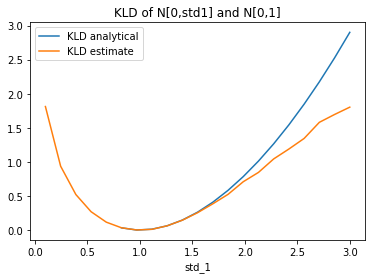

In [12]:
xval = [x[0] for x in vec]
yval = [x[1] for x in vec]
yval2 = [x[2] for x in vec]
plt.plot(xval,yval, label='KLD analytical')
plt.plot(xval,yval2, label='KLD estimate')
plt.title('KLD of N[0,std1] and N[0,1]')
plt.xlabel('std_1')
plt.legend()
plt.show()

We suppose that for empirical distributions with very different supports the result will deviate from expected due to lack of sampling some data

Convergence of the method

In [13]:
%%time

n_runs = 1000
n_simulations = 10
simulation_sizes = [500 + 1000 * i for i in range(n_simulations)]
μ1 = 0
μ2 = 1
std1 = 1
std2 = 1

dist_P = lambda x: scipy.stats.norm.pdf(x, μ1, std1)
dist_Q = lambda x: scipy.stats.norm.pdf(x, μ2, std2)
KLD = lambda x: dist_P(x)*np.log(dist_P(x)/dist_Q(x))
res, abserr = integrate.quad(KLD, -20, 30)

execution_times = []
results = []
result_std = []

for size in simulation_sizes:
    start = time.time()
    current_sim_results = []
    for sim in range(n_runs):
        P = np.random.normal(μ1, std1, size=size)
        Q = np.random.normal(μ2, std2, size=size)
        current_sim_results.append(KLD_PerezCruz(P, Q))

    results.append(np.mean(current_sim_results))
    result_std.append(np.std(current_sim_results)) 
    execution_times.append(time.time() - start)
    
results = np.array(results)
result_std = np.array(result_std)

Wall time: 1min 1s


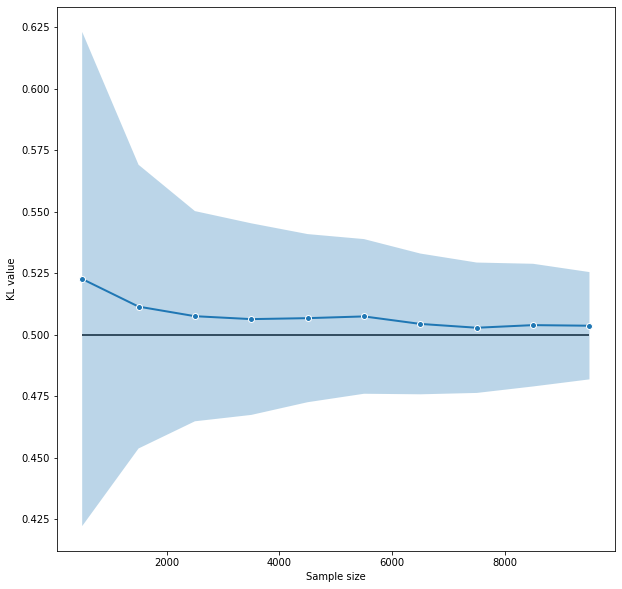

In [14]:
fig, ax = plt.subplots(1, figsize=(10,10))
positions = list(range(len(results)))
ax.plot(simulation_sizes, results, lw=2, marker='o', mec='white')
ax.fill_between(simulation_sizes, results + result_std, results - result_std, alpha=0.3)

#ax.set_title('KL converge for N(0, 1) and N(1, 1)', fontsize=24)
ax.set_ylabel('KL value')
ax.set_xlabel('Sample size')
ax.hlines(res, simulation_sizes[0], simulation_sizes[-1], color='black', alpha=1, zorder=-1)
plt.show()

Text(0, 0.5, 'KL calculation time (s)')

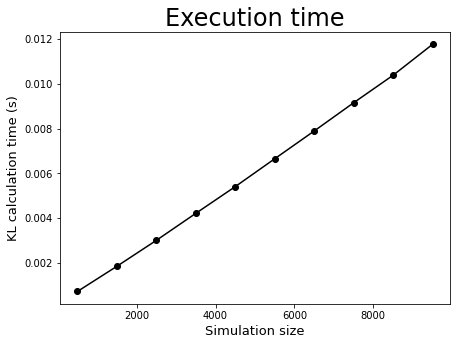

In [15]:
fig, ax = plt.subplots(1, figsize=(7, 5))

ax.plot(
    simulation_sizes,
    np.array(execution_times) / n_runs,
    color='black',
    marker='o',
)

ax.set_title('Execution time', fontsize=24)
ax.set_xlabel('Simulation size', fontsize=13)
ax.set_ylabel('KL calculation time (s)', fontsize=13)
